**Тема для анализа:**
Связь между уровнями атмосферного CO₂ и аномалиями глобальной поверхностной температуры Земли

**Данные по уровням CO₂ (Mauna Loa Observatory)**

*Источник:* NOAA Global Monitoring Laboratory.
*URL:* https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv

*Описание:* Глобальные ежемесячные средние концентрации CO₂ (в ppm) с 1979 года по настоящее время.

*Столбцы:*
- year: год измерения
- month: месяц измерения
- decimal: десятичная дата (комбинация года и месяца как дробь)
- average: средняя концентрация CO₂ за месяц
- average_unc: неопределённость среднего (среднее значение стандартных отклонений)
- trend: сглаженный тренд (удалена сезонность)
- ndays: количество дней с измерениями в месяце

Данные индексируются по дате (комбинация года и месяца)

**Данные по аномалиям глобальной температуры (NASA GISS)**

*Источник:* NASA Goddard Institute for Space Studies.
*URL:* https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv

*Описание:* Ежемесячные, сезонные и годовые аномалии глобальной температуры (отклонения от базового периода 1951–1980 годов, в °C) с 1880 года по настоящее время. 

*Столбцы:*
- Year: год
- Jan, Feb, ..., Dec: аномалии температуры за каждый месяц (*** для пропусков/незавершённых данных).
- J-D: годовое среднее (January-December)
- D-N: среднее за декабрь-ноябрь
- DJF, MAM, JJA, SON: сезонные средние (зима, весна, лето, осень)

**Гипотеза для исследования**
Существует положительная корреляция между концентрацией атмосферного CO₂ (в ppm) и аномалиями глобальной поверхностной температуры (в °C), что подтверждает антропогенный фактор увеличения CO₂ в атмосфере и как следствие явление глобального потепления

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка данных по CO₂
co2_url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv'
co2_df = pd.read_csv(co2_url, comment='#')  # Пропустить комментарии
co2_df['date'] = pd.to_datetime(co2_df['year'].astype(str) + '-' + co2_df['month'].astype(str) + '-01')
co2_df = co2_df.set_index('date')[['average']]  # Индекс по дате, взять среднее CO₂
co2_df.columns = ['CO2_ppm']

In [3]:
co2_df

,CO2_ppm
date,
1979-01-01,336.56
1979-02-01,337.29
1979-03-01,337.88
1979-04-01,338.32
1979-05-01,338.26
...,...
2025-02-01,426.39
2025-03-01,426.53
2025-04-01,426.82


In [4]:
# Загрузка данных по температуре
temp_url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
temp_df = pd.read_csv(temp_url, skiprows=1, na_values='***')  # Пропустить заголовок, заменить пропуски
# Melt в длинный формат для месяцев
temp_melt = pd.melt(temp_df, id_vars=['Year'], value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    var_name='Month', value_name='Temp_anomaly')
temp_melt['Month'] = temp_melt['Month'].map({'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
                                             'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12})
temp_melt['date'] = pd.to_datetime(temp_melt['Year'].astype(str) + '-' + temp_melt['Month'].astype(str) + '-01')
temp_melt = temp_melt.set_index('date')['Temp_anomaly'].dropna()  # Индекс по дате, удалить NaN

In [5]:
temp_melt

date
1880-01-01   -0.19
1881-01-01   -0.20
1882-01-01    0.16
1883-01-01   -0.29
1884-01-01   -0.13
              ... 
2020-12-01    0.79
2021-12-01    0.87
2022-12-01    0.80
2023-12-01    1.37
2024-12-01    1.27
Name: Temp_anomaly, Length: 1748, dtype: float64

In [6]:
# Объединение датасетов по дате (с 1979 года)
combined_df = pd.concat([co2_df, temp_melt], axis=1, join='inner').dropna()

In [7]:
combined_df

,CO2_ppm,Temp_anomaly
date,,
1979-01-01,336.56,0.09
1979-02-01,337.29,-0.10
1979-03-01,337.88,0.19
1979-04-01,338.32,0.15
1979-05-01,338.26,0.03
...,...,...
2025-02-01,426.39,1.25
2025-03-01,426.53,1.36
2025-04-01,426.82,1.23


In [8]:
# Нахождение корреляции
correlation = combined_df.corr().iloc[0,1]
print(f'Корреляция между CO₂ и температурными аномалиями: {correlation:.2f}')

Корреляция между CO₂ и температурными аномалиями: 0.89


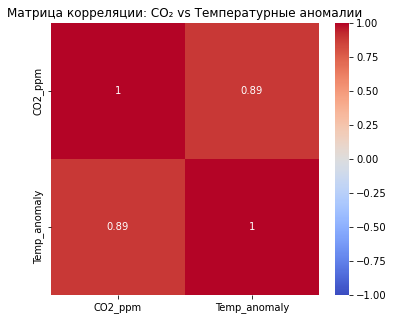

              CO2_ppm  Temp_anomaly
CO2_ppm        1.0000        0.8881
Temp_anomaly   0.8881        1.0000


In [15]:
# Матрица корреляции
correlation_matrix = combined_df[['CO2_ppm', 'Temp_anomaly']].corr()

# Визуализация
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Матрица корреляции: CO₂ vs Температурные аномалии')
plt.show()

print(correlation_matrix.round(4))

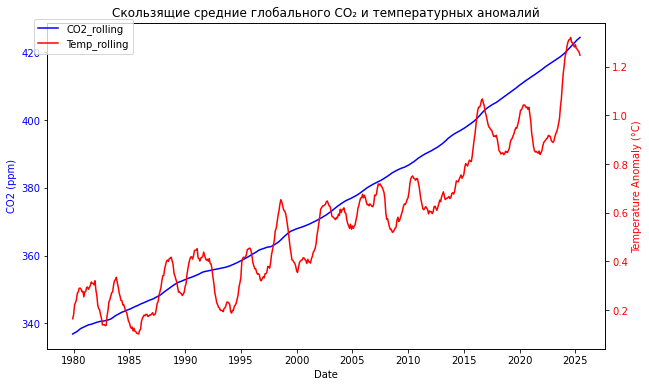

In [9]:
# Скользящие средние
combined_df['CO2_rolling'] = combined_df['CO2_ppm'].rolling(window=12).mean()
combined_df['Temp_rolling'] = combined_df['Temp_anomaly'].rolling(window=12).mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Левая ось для CO2_rolling (ppm)
ax1.plot(combined_df.index, combined_df['CO2_rolling'], 'b-', label='CO2_rolling')
ax1.set_xlabel('Date')
ax1.set_ylabel('CO2 (ppm)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Правая ось для Temp_rolling (°C)
ax2 = ax1.twinx()
ax2.plot(combined_df.index, combined_df['Temp_rolling'], 'r-', label='Temp_rolling')
ax2.set_ylabel('Temperature Anomaly (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Скользящие средние глобального CO₂ и температурных аномалий')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.show()

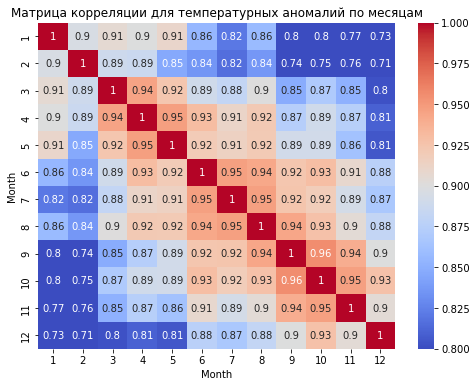

In [11]:
# Извлечение года и месяца из индекса (если combined_df индексирован по date)
combined_df.reset_index(inplace=True)
combined_df['Year'] = combined_df['date'].dt.year
combined_df['Month'] = combined_df['date'].dt.month

# Для Temp_anomaly: pivot в широкий формат по месяцам
temp_pivot = combined_df.pivot(index='Year', columns='Month', values='Temp_anomaly').dropna(how='all')

# Матрица корреляции для Temp_anomaly по месяцам
temp_corr = temp_pivot.corr()

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(temp_corr, annot=True, cmap='coolwarm', vmin=0.8, vmax=1, center=0.9)
plt.title('Матрица корреляции для температурных аномалий по месяцам')
plt.show()

In [12]:
combined_df

,index,date,CO2_ppm,Temp_anomaly,CO2_rolling,Temp_rolling,Year,Month
0,0,1979-01-01,336.56,0.09,NaN,NaN,1979,1
1,1,1979-02-01,337.29,-0.10,NaN,NaN,1979,2
2,2,1979-03-01,337.88,0.19,NaN,NaN,1979,3
3,3,1979-04-01,338.32,0.15,NaN,NaN,1979,4
4,4,1979-05-01,338.26,0.03,NaN,NaN,1979,5
...,...,...,...,...,...,...,...,...
553,553,2025-02-01,426.39,1.25,423.407500,1.274167,2025,2
554,554,2025-03-01,426.53,1.36,423.667500,1.271667,2025,3
555,555,2025-04-01,426.82,1.23,423.911667,1.265000,2025,4
556,556,2025-05-01,426.79,1.07,424.149167,1.259167,2025,5


C:\Users\shari\AppData\Local\Temp\ipykernel_15768\2096560212.py:18: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  common_idx = temp_col.index & co2_col.index


        1       2       3       4       5       6       7       8       9   \
1   0.8360  0.8363  0.8366  0.8369  0.8375  0.8384  0.8237  0.8240  0.8243   
2   0.7954  0.7953  0.7956  0.7965  0.7971  0.7982  0.7815  0.7813  0.7812   
3   0.8880  0.8880  0.8881  0.8884  0.8887  0.8890  0.8795  0.8801  0.8803   
4   0.9153  0.9155  0.9157  0.9159  0.9160  0.9162  0.9088  0.9094  0.9100   
5   0.9180  0.9182  0.9181  0.9182  0.9190  0.9195  0.9130  0.9140  0.9145   
6   0.9273  0.9273  0.9277  0.9284  0.9289  0.9290  0.9233  0.9238  0.9244   
7   0.9185  0.9184  0.9185  0.9190  0.9194  0.9196  0.9197  0.9205  0.9212   
8   0.9231  0.9231  0.9235  0.9239  0.9245  0.9254  0.9258  0.9263  0.9269   
9   0.9174  0.9176  0.9177  0.9182  0.9188  0.9190  0.9191  0.9196  0.9204   
10  0.9397  0.9402  0.9405  0.9408  0.9410  0.9408  0.9406  0.9410  0.9419   
11  0.9000  0.9005  0.9005  0.9006  0.9009  0.9011  0.9011  0.9013  0.9018   
12  0.8551  0.8555  0.8561  0.8567  0.8569  0.8571  0.8567  0.85

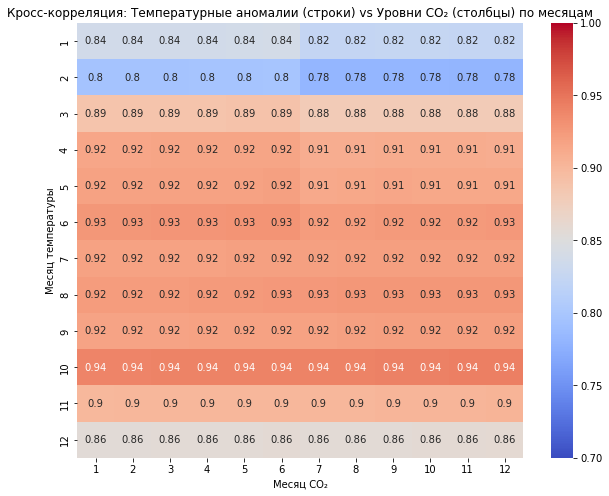

In [13]:
# Pivot для Temp и CO2 (широкий формат по месяцам)
temp_pivot = combined_df.pivot(index='Year', columns='Month', values='Temp_anomaly')
co2_pivot = combined_df.pivot(index='Year', columns='Month', values='CO2_ppm')

# Общие годы
common_years = list(set(temp_pivot.index) & set(co2_pivot.index))
temp_pivot = temp_pivot.loc[common_years].sort_index()
co2_pivot = co2_pivot.loc[common_years].sort_index()

# Кросс-корреляционная матрица
months = list(range(1, 13))
corr_matrix = pd.DataFrame(index=months, columns=months, dtype=float)
for i in months:
    for j in months:
        if i in temp_pivot.columns and j in co2_pivot.columns:
            temp_col = temp_pivot[i].dropna()
            co2_col = co2_pivot[j].reindex(temp_col.index).dropna()
            common_idx = temp_col.index & co2_col.index
            if len(common_idx) > 1:
                corr_matrix.loc[i, j] = np.corrcoef(temp_col.loc[common_idx], co2_col.loc[common_idx])[0, 1]
            else:
                corr_matrix.loc[i, j] = np.nan

# Вывод матрицы
print(corr_matrix.round(4))

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0.7, vmax=1, center=0.85)
plt.title('Кросс-корреляция: Температурные аномалии (строки) vs Уровни CO₂ (столбцы) по месяцам')
plt.xlabel('Месяц CO₂')
plt.ylabel('Месяц температуры')
plt.show()